<a href="https://colab.research.google.com/github/Imenatrix/TCC-INFO19/blob/master/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
%%capture
!sudo add-apt-repository -y ppa:openjdk-r/ppa
!sudo apt-get purge openjdk-*
!sudo apt-get install openjdk-8-jdk

In [2]:
%%capture
!pip3 install minerl

# Dependencies

In [3]:
import os
import time
import copy

from itertools import product
from collections import OrderedDict

import minerl
import numpy as np
import tensorflow as tf

from matplotlib import pyplot as plt

from keras import Model
from keras.layers import *
from tensorflow import keras

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


# Wrappers

In [4]:
wrappers = {}

def register_wrapper(name, wrapper):
    wrappers[name] = wrapper

## Amiranas

In [5]:
class ActionManager:
    """Main minecraft action wrapper. Simplifies action space to 130 discrete actions"""

    def __init__(self, c_action_magnitude=22.5):
        self.c_action_magnitude = c_action_magnitude

        self.zero_action = OrderedDict([('attack', 0),
                                        ('back', 0),
                                        ('camera', np.array([0., 0.])),
                                        ('forward', 0),
                                        ('jump', 0),
                                        ('left', 0),
                                        ('right', 0),
                                        ('sneak', 0),
                                        ('sprint', 0)])

        # camera discretization:
        self.camera_dict = OrderedDict([
            ('turn_up', np.array([-c_action_magnitude, 0.])),
            ('turn_down', np.array([c_action_magnitude, 0.])),
            ('turn_left', np.array([0., -c_action_magnitude])),
            ('turn_right', np.array([0., c_action_magnitude]))
        ])

        self.fully_connected_no_camera = ['attack', 'back', 'forward', 'jump', 'left', 'right', 'sprint']
        self.camera_actions = ['turn_up', 'turn_down', 'turn_left', 'turn_right']
        self.fully_connected = self.fully_connected_no_camera + self.camera_actions

        # following action combinations are excluded:
        self.exclude = [('forward', 'back'), ('left', 'right'), ('attack', 'jump'),
                        ('turn_up', 'turn_down', 'turn_left', 'turn_right')]

        # sprint only allowed when forward is used:
        self.only_if = [('sprint', 'forward')]

        # Maximal allowed mount of actions within one action:
        self.remove_size = 3

        # if more than 3 actions are present, actions are removed using this list until only 3 actions remain:
        self.remove_first_list = ['sprint', 'left', 'right', 'back',
                                  'turn_up', 'turn_down', 'turn_left', 'turn_right',
                                  'attack', 'jump', 'forward']

        self.fully_connected_list = list(product(range(2), repeat=len(self.fully_connected)))

        remove = []
        for el in self.fully_connected_list:
            for tuple_ in self.exclude:
                if sum([el[self.fully_connected.index(a)] for a in tuple_]) > 1:
                    if el not in remove:
                        remove.append(el)
            for a, b in self.only_if:
                if el[self.fully_connected.index(a)] == 1 and el[self.fully_connected.index(b)] == 0:
                    if el not in remove:
                        remove.append(el)
            if sum(el) > self.remove_size:
                if el not in remove:
                    remove.append(el)

        for r in remove:
            self.fully_connected_list.remove(r)

        self.action_list = []
        for el in self.fully_connected_list:
            new_action = copy.deepcopy(self.zero_action)
            for key, value in zip(self.fully_connected, el):
                if key in self.camera_actions:
                    if value:
                        new_action['camera'] = self.camera_dict[key]
                else:
                    new_action[key] = value
            self.action_list.append(new_action)

        self.num_action_ids_list = [len(self.action_list)]
        self.act_continuous_size = 0

    def get_action(self, id_):
        a = copy.deepcopy(self.action_list[int(id_)])
        a['camera'] += np.random.normal(0., 0.5, 2)
        return a

    def print_action(self, id_):
        a = copy.deepcopy(self.action_list[int(id_)])
        out = ""
        for k, v in a.items():
            if k != 'camera':
                if v != 0:
                    out += f'{k} '
            else:
                if (v != np.zeros(2)).any():
                    out += k

        print(out)

    def get_id(self, action, batch_size):

        coiso = np.zeros((batch_size,), dtype=int)
        action = copy.deepcopy(action)
        for i in range(batch_size):

            # discretize 'camera':
            camera = action['camera'][i]
            camera_action_amount = 0
            if - self.c_action_magnitude / 2. < camera[0] < self.c_action_magnitude / 2.:
                action['camera'][i][0] = 0.
                if - self.c_action_magnitude / 2. < camera[1] < self.c_action_magnitude / 2.:
                    action['camera'][i][1] = 0.
                else:
                    camera_action_amount = 1
                    action['camera'][i][1] = self.c_action_magnitude * np.sign(camera[1])
            else:
                camera_action_amount = 1
                action['camera'][i][0] = self.c_action_magnitude * np.sign(camera[0])

                action['camera'][i][1] = 0.

            # simplify action:
            for tuple_ in self.exclude:
                if len(tuple_) == 2:
                    a, b = tuple_
                    if action[a][i] and action[b][i]:
                        action[b][i] = 0
            for a, b in self.only_if:
                if not action[b][i]:
                    if action[a][i]:
                        action[a][i] = 0
            for a in self.remove_first_list:
                if sum([action[key][i] for key in self.fully_connected_no_camera]) > \
                        (self.remove_size - camera_action_amount):
                    if a in self.camera_actions:
                        action['camera'][i] = np.array([0., 0.])
                        camera_action_amount = 0
                    else:
                        action[a][i] = 0
                else:
                    break

            # set one_hot camera keys:
            for key in self.camera_actions:
                action[key] = [0 for x in range(batch_size)]
            for key, val in self.camera_dict.items():
                if (action['camera'][i] == val).all():
                    action[key][i] = 1
                    break

            non_separate_values = tuple(action[key][i] for key in self.fully_connected)

            coiso[i] = self.fully_connected_list.index(non_separate_values)
        return coiso

    def get_left_right_reversed_mapping(self):
        action_mapping = []
        for action in self.action_list:
            reversed_action = copy.deepcopy(action)
            if action['left'] == 1:
                reversed_action['left'] = 0
                reversed_action['right'] = 1
                assert action['right'] == 0
            if action['right'] == 1:
                reversed_action['right'] = 0
                reversed_action['left'] = 1
                assert action['left'] == 0
            if (action['camera'] == [0, -22.5]).all():
                reversed_action['camera'][1] = 22.5
            if (action['camera'] == [0, 22.5]).all():
                reversed_action['camera'][1] = -22.5

            rev_action_id = self.get_id(reversed_action)
            action_mapping.append(rev_action_id)

        return action_mapping

manager = ActionManager()
register_wrapper('amiranas', manager.get_id)

## Baseline Notebook

In [6]:
def dataset_action_batch_to_actions(dataset_actions, batch_size, camera_margin=3):
    """
    Turn a batch of actions from dataset (`batch_iter`) to a numpy
    array that corresponds to batch of actions of ActionShaping wrapper (_actions).

    Camera margin sets the threshold what is considered "moving camera".

    Note: Hardcoded to work for actions in ActionShaping._actions, with "intuitive"
        ordering of actions.
        If you change ActionShaping._actions, remember to change this!

    Array elements are integers corresponding to actions, or "-1"
    for actions that did not have any corresponding discrete match.
    """
    # There are dummy dimensions of shape one
    camera_actions = dataset_actions["camera"].squeeze()
    attack_actions = dataset_actions["attack"].squeeze()
    forward_actions = dataset_actions["forward"].squeeze()
    jump_actions = dataset_actions["jump"].squeeze()
    actions = np.zeros((batch_size,), dtype=int)

    for i in range(batch_size):
        # Moving camera is most important (horizontal first)
        if camera_actions[i][0] < -camera_margin:
            actions[i] = 4
        elif camera_actions[i][0] > camera_margin:
            actions[i] = 5
        elif camera_actions[i][1] > camera_margin:
            actions[i] = 6
        elif camera_actions[i][1] < -camera_margin:
            actions[i] = 7
        elif forward_actions[i] == 1:
            if jump_actions[i] == 1:
                actions[i] = 3
            else:
                actions[i] = 2
        elif attack_actions[i] == 1:
            actions[i] = 1
        else:
            # No reasonable mapping (would be no-op)
            actions[i] = 0
    return actions

register_wrapper('baseline_notebook', dataset_action_batch_to_actions)

# Data

In [7]:
%env MINERL_DATA_ROOT=/home/minerl

env: MINERL_DATA_ROOT=/home/minerl


In [8]:
!python3 -m minerl.data.download --environment "MineRLTreechop-v0"

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/usr/lib/python3.7/runpy.py:125: RuntimeWarning: 'minerl.data.download' found in sys.modules after import of package 'minerl.data', but prior to execution of 'minerl.data.download'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
2022-06-22 00:30:05 e36bbd7a018e __main__[3696] INFO Downloading dataset for MineRLTreechop-v0 to /home/minerl
2022-06-22 00:30:05 e36bbd7a018e __main__[3696] INFO Starting download ...
2022-06-22 00:30:05 e36bbd7a018e root[3696] DEBUG Choosing mirror ...
2022-06-22 00:30:05 e36bbd7a018e root[3696] DEBUG Picked https://minerl.s3.amazonaws.com/v4/MineRLTreechop-v0.tar ping=312.103ms
2022-06-22 00:30:05 e36bbd7a018e root[3696] DEBUG Starting download at 0.0MB
2022-06-22 00:30:06 e36bbd7a018e root[3696] DEBUG File size is 1510.7MB
Download: https://mi

In [9]:
def bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def float_feature(value):
  """Returns a float_list from a float / double."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def int64_list_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=value))

In [10]:
def encode_example(obs, action_id):
  feature = {
      'obs' : bytes_feature(tf.io.serialize_tensor(obs)),
      'action_id' : int64_feature(action_id)
  }
  return tf.train.Example(features=tf.train.Features(feature=feature))


#@tf.function
def decode_example(example):
  feature_description = {
    "obs": tf.io.FixedLenFeature([], tf.string),
    "action_id": tf.io.FixedLenFeature([], tf.int64)
  }
  example = tf.io.parse_single_example(example, feature_description)
  return tf.io.parse_tensor(example['obs'], out_type=tf.float32), example['action_id']

In [11]:
def preprocess_expert_data(wrapper, examples_per_file, dataset_dir):
    wrap = wrappers[wrapper]

    data = minerl.data.make('MineRLTreechop-v0')
    iterator = minerl.data.BufferedBatchIter(data, 30000)

    try:
        os.makedirs(dataset_dir)
    except:
        pass

    i = 0
    for current_state, action, reward, next_state, done in iterator.buffered_batch_iter(examples_per_file, num_epochs=1):
        obs = current_state["pov"].squeeze().astype(np.float32) / 255
        action_id = wrap(action, examples_per_file).squeeze()
        
        with tf.io.TFRecordWriter(f'{dataset_dir}/{i}.tfrecord') as writer:
            for x in range(examples_per_file):
                example = encode_example(obs[x], action_id[x])
                writer.write(example.SerializeToString())

        i += 1


In [12]:
def listdir(dir):
    return list(map(
        lambda file: dir + '/' + file,
        os.listdir(dir)
    ))

In [13]:
def create_dataset(filenames, batch_size):
    AUTOTUNE = tf.data.AUTOTUNE

    ignore_order = tf.data.Options()
    ignore_order.deterministic = False  # disable order, increase speed

    return (
        tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTOTUNE)
            .with_options(ignore_order)
            .map(decode_example, num_parallel_calls=AUTOTUNE)
            .repeat()
            .batch(batch_size, num_parallel_calls=AUTOTUNE)
            .prefetch(AUTOTUNE)
    )

# Trainers

## DQN Epsilon Keras

In [14]:
def train(model, model_target, env):

    num_actions = 4

    seed = 42
    gamma = 0.99
    epsilon = 1.0
    epsilon_min = 0.1
    epsilon_max = 1.0
    epsilon_interval = (
        epsilon_max - epsilon_min
    )
    batch_size = 32
    max_steps_per_episode = 10000

    env.seed(seed)

    optimizer = keras.optimizers.Adam(learning_rate=0.00025, clipnorm=1.0)
    loss_function = keras.losses.Huber()

    action_history = []
    state_history = []
    state_next_history = []
    rewards_history = []
    done_history = []
    episode_reward_history = []

    frame_sample = []

    running_reward = 0
    episode_count = 0
    frame_count = 0

    epsilon_random_frames = 50000
    epsilon_greedy_frames = 10000000

    max_memory_length = 100000

    update_after_actions = 4
    update_target_network = 1000

    while True:
        state = np.array(env.reset())
        episode_reward = 0

        start = time.time()
        for timestep in range(1, max_steps_per_episode):

            end = time.time()
            frame_sample.append(end - start)
            if len(frame_sample) == 60 * 5:
                coiso = np.mean(frame_sample)
                print(f'FPS: {1 / coiso}')
                frame_sample = []
            start = time.time()

            #env.render()
            frame_count += 1

            if frame_count < epsilon_random_frames or epsilon > np.random.rand(1)[0]:
                action = np.random.choice(num_actions)
            else:
                state_tensor = tf.convert_to_tensor(state)
                state_tensor = tf.expand_dims(state_tensor, 0)
                action_probs = model(state_tensor, training=False)
                action = tf.argmax(action_probs[0]).numpy()
            
            epsilon -= epsilon_interval / epsilon_greedy_frames
            epsilon = max(epsilon, epsilon_min)

            state_next, reward, done, _ = env.step(action)
            state_next = np.array(state_next)

            episode_reward += reward

            action_history.append(action)
            state_history.append(state)
            state_next_history.append(state_next)
            done_history.append(done)
            rewards_history.append(reward)
            state = state_next

            if frame_count % update_after_actions == 0 and len(done_history) > batch_size:
                
                indices = np.random.choice(range(len(done_history)), size=batch_size)

                state_sample = np.array([state_history[i] for i in indices])
                state_next_sample = np.array([state_next_history[i] for i in indices])
                rewards_sample = np.array([rewards_history[i] for i in indices])
                action_sample = np.array([action_history[i] for i in indices])
                done_sample = tf.convert_to_tensor(
                    [float(done_history[i]) for i in indices]
                )

                future_rewards = predict_target(model_target, state_next_sample)
                updated_q_values = rewards_sample + gamma * tf.reduce_max (
                    future_rewards, axis=1
                )
                updated_q_values = updated_q_values * (1 - done_sample) - done_sample

                masks = tf.one_hot(action_sample, num_actions)

                backpropagation(model, optimizer, loss_function, state_sample, updated_q_values, masks)

            if frame_count % update_target_network == 0:
                model_target.set_weights(model.get_weights())
                template = 'running reward: {:.2f} at episode {}, frame count {}'
                print(template.format(running_reward, episode_count, frame_count))

            if len(rewards_history) > max_memory_length:
                del rewards_history[:1]
                del state_history[:1]
                del state_next_history[:1]
                del action_history[:1]
                del done_history[:1]

            if done:
                break

            episode_reward_history.append(episode_reward)
            if len(episode_reward_history) > 100:
                del episode_reward_history[:1]
            running_reward = np.mean(episode_reward_history)

            episode_count += 1

            if running_reward > 40:
                print('Solved at episode {}!'.format(episode_count))
                break

@tf.function
def predict_target(model_target, state_next_sample):
    future_rewards = model_target(state_next_sample)
    return future_rewards

@tf.function
def backpropagation(model, optimizer, loss_function, state_sample, updated_q_values, masks):
    with tf.GradientTape() as tape:
        q_values = model(state_sample)
        q_action = tf.reduce_sum(tf.multiply(q_values, masks), axis=1)
        loss = loss_function(updated_q_values, q_action)

    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

# Models

In [15]:
models = {}

def register_model(name, model):
    models[name] = model

## Deepmind Atari

In [16]:
def deepmind_atari(input_shape, nb_outputs):
    inputs = Input(shape=input_shape)
    
    x = Conv2D(32, 8, strides=4, activation='relu')(inputs)
    x = Conv2D(64, 4, strides=4, activation='relu')(x)
    x = Conv2D(64, 3, strides=1, activation='relu')(x)

    x = Flatten()(x)

    x = Dense(512, activation='relu')(x)
    output = Dense(nb_outputs, activation='linear')(x)

    return Model(inputs=inputs, outputs=output)

register_model('deepmind_atari', deepmind_atari)

## Xception

In [30]:
def xception(input_shape, nb_outputs):
    inputs = Input(shape=input_shape)

    # Entry block
    x = Rescaling(1.0 / 255)(inputs)
    x = Conv2D(32, 3, strides=2, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(64, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = Activation("relu")(x)
        x = SeparableConv2D(size, 3, padding="same")(x)
        x = BatchNormalization()(x)

        x = Activation("relu")(x)
        x = SeparableConv2D(size, 3, padding="same")(x)
        x = BatchNormalization()(x)

        x = MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = SeparableConv2D(1024, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    
    outputs = Dense(nb_outputs, activation='linear')(x)
    return Model(inputs, outputs)

register_model('xception', xception)

# Main

In [25]:
WRAPPER = 'amiranas'
MODEL = 'xception'

EPOCHS = 10
BATCH_SIZE = 64
EXAMPLES_PER_FILE = 256

CHECKPOINT = '/content/drive/MyDrive/weights/checkpoint'
DATASET_DIR = '/home/minerl/tfrecords'

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [19]:
%%capture
preprocess_expert_data(WRAPPER, EXAMPLES_PER_FILE, DATASET_DIR)

In [22]:
filenames = listdir(DATASET_DIR)
validation_split = 0.1
split = len(filenames) - int(len(filenames) * validation_split)
train_fns = filenames[:split]
validation_fns = filenames[split:]

dataset = create_dataset(train_fns, BATCH_SIZE)
val_dataset = create_dataset(validation_fns, BATCH_SIZE)

In [26]:
model = models[MODEL]((64, 64, 3), 112)

optimizer = tf.keras.optimizers.Adam()
val_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model.compile(optimizer, loss_fn, metrics=[val_acc_metric])

In [ ]:
model.load_weights(CHECKPOINT)

In [27]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=CHECKPOINT, save_weights_only=True, save_best_only=True)

In [28]:
steps_per_epoch = len(train_fns) * EXAMPLES_PER_FILE / BATCH_SIZE
validation_steps = len(validation_fns) * EXAMPLES_PER_FILE / BATCH_SIZE

history = model.fit(dataset, validation_data=val_dataset, steps_per_epoch=steps_per_epoch, validation_steps=validation_steps, epochs=EPOCHS, callbacks=[model_checkpoint_callback])

Epoch 1/10
6324/6324 [==============================] - 306s 46ms/step - loss: 1.2863 - sparse_categorical_accuracy: 0.6570 - val_loss: 24.6633 - val_sparse_categorical_accuracy: 0.5665
Epoch 2/10
6324/6324 [==============================] - 292s 46ms/step - loss: 1.1383 - sparse_categorical_accuracy: 0.6858 - val_loss: 11.1826 - val_sparse_categorical_accuracy: 0.5665
Epoch 3/10
6324/6324 [==============================] - 292s 46ms/step - loss: 1.0426 - sparse_categorical_accuracy: 0.7063 - val_loss: 3.5535 - val_sparse_categorical_accuracy: 0.5665
Epoch 4/10
6324/6324 [==============================] - 443s 70ms/step - loss: 0.9508 - sparse_categorical_accuracy: 0.7268 - val_loss: 3.9736 - val_sparse_categorical_accuracy: 0.5684
Epoch 5/10
6324/6324 [==============================] - 506s 80ms/step - loss: 0.8661 - sparse_categorical_accuracy: 0.7455 - val_loss: 50.0417 - val_sparse_categorical_accuracy: 0.5665
Epoch 6/10
6324/6324 [==============================] - 507s 80ms/step -

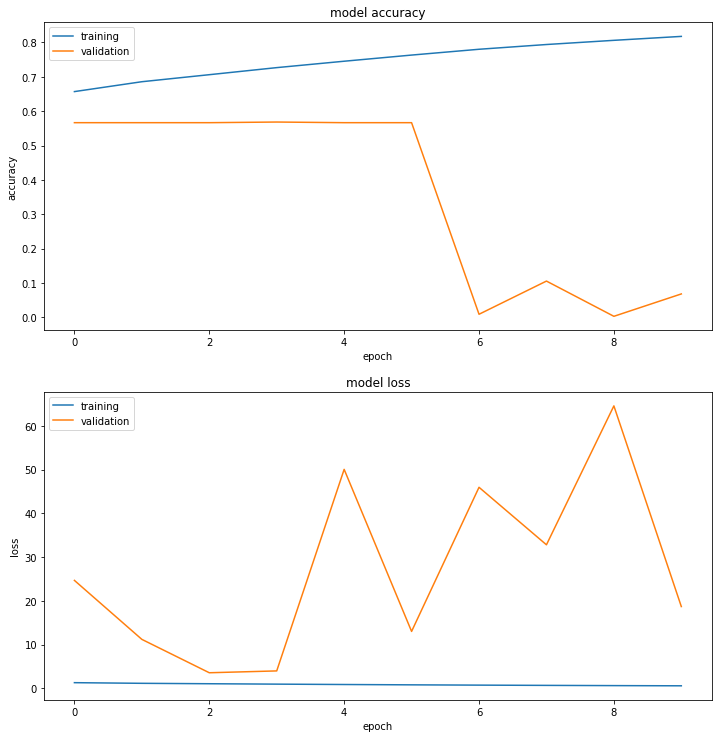

In [29]:
def display_training_curves(training, validation, title, subplot):
  ax = plt.subplot(subplot)
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['training', 'validation'])

plt.subplots(figsize=(10,10))
plt.tight_layout()
display_training_curves(history.history['sparse_categorical_accuracy'], history.history['val_sparse_categorical_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)